### Evaluating performance and drift of in hospital mortality model (xgboost) using a rolling window

In [1]:
import os
import random
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import scipy.stats as st
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from datetime import date, timedelta
import numpy as np, scipy.stats as st

sys.path.append("../..")

from gemini.utils import *
from drift_detector.utils import *
from drift_detector.rolling_window import *
from drift_detector.detector import Detector
from drift_detector.reductor import Reductor
from drift_detector.tester import TSTester, DCTester
from baseline_models.temporal.pytorch.optimizer import Optimizer
from baseline_models.temporal.pytorch.utils import *
from drift_detection.baseline_models.static.utils import run_model

2022-10-14 09:44:45,037 INFO cyclops.orm     - Database setup, ready to run queries!


In [2]:
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022/"
TIMESTEPS = 6
AGGREGATION_TYPE = "time_flatten"
HOSPITALS = ["SMH", "MSH", "THPC", "THPM", "UHNTG", "UHNTW", "PMH","SBK"]
OUTCOME = "mortality"
THRESHOLD=0.05
NUM_TIMESTEPS = 6
STAT_WINDOW=30
LOOKUP_WINDOW=0
STRIDE=1

SHIFT = input("Select experiment: ")  
MODEL_PATH = os.path.join(PATH,"saved_models",SHIFT+"_lstm.pt")

if SHIFT == "simulated_deployment":
    exp_params = {
        'source': [datetime.date(2015, 1, 1),datetime.date(2019, 1, 1)],
        'target': [datetime.date(2019, 1, 1), datetime.date(2020, 8, 1)],
        'shift_type': "source_target"
    }
    
if SHIFT == "covid":
    exp_params = {
        'source': [datetime.date(2019, 1, 1), datetime.date(2020, 2, 1)],
        'target': [datetime.date(2020, 3, 1), datetime.date(2020, 8, 1)],
        'shift_type': "time"
    }

if SHIFT == "seasonal_summer":
    exp_params = {
        'source': [1,2,3,4,5,10,11,12],
        'target': [6,7,8,9],
        'shift_type': "month"
    }

if SHIFT == "seasonal_winter":
    exp_params = {
        'source': [3,4,5,6,7,8,9,10],
        'target': [11,12,1,2],
        'shift_type': "month"
    }

Select experiment:  covid


## Get data

In [3]:
admin_data, x, y = get_gemini_data(PATH)

2022-10-14 09:45:01,669 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-10-14 09:45:02,115 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-10-14 09:45:02,297 INFO cyclops.feature_handler - Loading features from file...
2022-10-14 09:45:02,302 INFO cyclops.feature_handler - Found file to load for static features...
2022-10-14 09:45:02,306 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-10-14 09:45:02,348 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-10-14 09:45:07,530 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-10-14 09:45:16,648 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet


## Set constant reference distribution

In [4]:
random.seed(1)

(X_tr, y_tr), (X_val, y_val), (X_t, y_t), feats, admin_data = import_dataset_hospital(admin_data, x, y, SHIFT, OUTCOME, HOSPITALS)

# Normalize data
X_tr_normalized  = normalize(admin_data, X_tr, AGGREGATION_TYPE, TIMESTEPS)
X_val_normalized = normalize(admin_data, X_val, AGGREGATION_TYPE, TIMESTEPS)
X_t_normalized = normalize(admin_data, X_t, AGGREGATION_TYPE, TIMESTEPS)

if AGGREGATION_TYPE != "time":
    y_tr = get_label(admin_data, X_tr, OUTCOME)
    y_val = get_label(admin_data, X_val, OUTCOME)
    y_t = get_label(admin_data, X_t, OUTCOME)
    
# Scale data
X_tr_scaled = scale(X_tr_normalized)
X_val_scaled = scale(X_val_normalized)
X_t_scaled = scale(X_t_normalized)

# Process data
X_tr_final = process(X_tr_scaled, AGGREGATION_TYPE, TIMESTEPS)
X_val_final = process(X_val_scaled, AGGREGATION_TYPE, TIMESTEPS)
X_t_final = process(X_t_scaled, AGGREGATION_TYPE, TIMESTEPS)

## Create data streams

In [5]:
START_DATE = date(2019, 1, 1)
END_DATE = date(2020, 8, 1)

In [6]:
print("Get target data streams...")
data_streams = get_serving_data(
    x, 
    y, 
    admin_data, 
    START_DATE, 
    END_DATE, 
    stride=1, 
    window=1, 
    encounter_id='encounter_id', 
    admit_timestamp='admit_timestamp'
)

Get target data streams...
2019-01-01 - 2019-01-02
2020-01-01 - 2020-01-02


## Get prediction model

In [7]:
MODEL_NAME = input("Select Model: ")
MODEL_PATH = PATH + "_".join([SHIFT, OUTCOME, '_'.join(HOSPITALS), MODEL_NAME]) + ".pkl"
if os.path.exists(MODEL_PATH):
    optimised_model = pickle.load(open(MODEL_PATH, "rb"))
else:
    optimised_model = run_model(MODEL_NAME, X_tr_final, y_tr, X_val_final, y_val)
    pickle.dump(optimised_model, open(MODEL_PATH, 'wb'))

Select Model:  xgb


In [8]:
DR_TECHNIQUE="BBSDs_untrained_FFNN"
MD_TEST="mmd"
SAMPLE=1000
CONTEXT_TYPE="ffnn"
PROJ_TYPE="ffnn"

print("Get Shift Reductor...")
reductor = Reductor(
    dr_method = DR_TECHNIQUE,
    n_features = len(feats)*TIMESTEPS,
    var_ret = 0.8,
)
    
print("Get Shift Tester...")
tester = TSTester(
    tester_method=MD_TEST
)
    
print("Get Shift Detector...")
detector = Detector(
    reductor = reductor,
    tester = tester,
    p_val_threshold = 0.05,
)
detector.fit(X_val_final)

Get Shift Reductor...
Get Shift Tester...
Get Shift Detector...


2022-10-14 09:50:34.880820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 09:50:34.996920: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mnt/nfs/home/subasriv/.cache/pypoetry/virtualenvs/cyclops-KKtuQLwg-py3.9/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/opt/R/4.0.5/lib/R/lib:/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
2022-10-14 09:50:34.996986: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu

In [ ]:
print("Get Rolling Window...")

rolling_window = RollingWindow(
    admin_data = admin_data,
    shift_detector = detector,
    model=optimised_model
)

all_runs = []
for i in range(0,1):
    random.seed(1)
    np.random.seed(1)
    
    drift_metrics = rolling_window.drift(  
        data_streams=data_streams,
        sample=SAMPLE,
        stat_window=STAT_WINDOW,
        lookup_window=LOOKUP_WINDOW,
        stride=STRIDE,
        model_path=MODEL_PATH,
        context_type=CONTEXT_TYPE,
        proj_type=PROJ_TYPE,
        aggregation_type=AGGREGATION_TYPE
    )
        
    performance_metrics = rolling_window.performance(
        data_streams=data_streams,
        stat_window=STAT_WINDOW,
        lookup_window=LOOKUP_WINDOW,
        stride=STRIDE,
        aggregation_type=AGGREGATION_TYPE
    )
    
    results = {'timestamps':[(datetime.datetime.strptime(date,"%Y-%m-%d")+datetime.timedelta(days=LOOKUP_WINDOW+STAT_WINDOW)).strftime("%Y-%m-%d") for date in data_streams['timestamps']][:-STAT_WINDOW]}
    results.update(drift_metrics)
    results.update(performance_metrics)
    
    all_runs.append(results)
#np.save(os.path.join(PATH, shift, shift+"_rolling_window.npy"), all_runs)

In [10]:
avgDict = {}
for k,v in results.items():
    if not all(isinstance(s, str) for s in v):
        mean = sum(v)/ float(len(v))
        ci = st.t.interval(0.95, len(v), loc=np.mean(v), scale=st.sem(v))
        avgDict[k] = [mean, ci]
avgDict

{'distance': [0.00037800044493567676,
  (0.00021853383267100704, 0.000537467034442464)],
 'p_val': [0.42556390977443637, (0.40230994960531496, 0.4488178699435572)],
 'shift_detected': [0.06390977443609022,
  (0.04305850563000897, 0.08476104324217147)],
 'acc': [0.5037643902732017, (0.501302724060415, 0.5062260578304542)],
 'rec1': [0.5067546290898681, (0.5025334269205392, 0.510975727399224)],
 'prec0': [0.5007287949547732, (0.495651141639414, 0.5058063111346338)],
 'auroc': [0.5009616593303979, (0.49821944163271464, 0.503703877028081)],
 'prec1': [0.5018531459950863, (0.4968978674128615, 0.5068084686085618)],
 'rec0': [0.49589429918984723, (0.49154287861450724, 0.500245687498011)],
 'minpse': [0.5225014783073917, (0.5180732086050143, 0.5269297480097695)],
 'auprc': [0.5060179830817255, (0.5010685455727054, 0.5109674205907454)]}

## Plot Drift and Prediction Performance

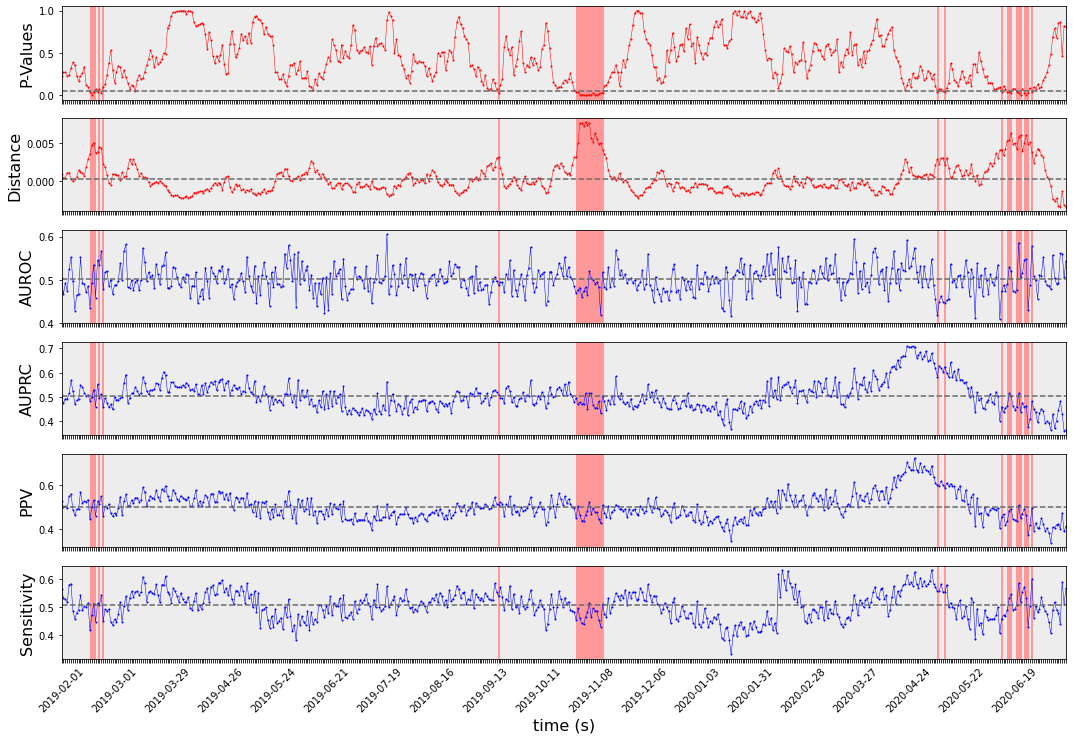

In [13]:
threshold=0.05
sig_drift = np.array(results['shift_detected'])[np.newaxis]

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(18,12))
cmap = ListedColormap(['lightgrey','red'])
ax1.plot(results['timestamps'], results['p_val'], '.-', color="red", linewidth=0.5, markersize=2)
ax1.set_xlim(results['timestamps'][0], results['timestamps'][-1])
ax1.axhline(y=threshold, color='dimgrey', linestyle='--')
ax1.set_ylabel('P-Values',fontsize=16)
ax1.set_xticklabels([])
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),sig_drift, cmap = cmap, alpha = 0.4)
  
ax2.plot(results['timestamps'], results['distance'], '.-',color="red", linewidth=0.5, markersize=2)
ax2.set_xlim(results['timestamps'][0], results['timestamps'][-1])
ax2.set_ylabel('Distance',fontsize=16)
ax2.axhline(y=np.mean(results['distance']), color='dimgrey', linestyle='--')
ax2.set_xticklabels([])
ax2.pcolorfast(ax2.get_xlim(), ax2.get_ylim(),sig_drift, cmap = cmap, alpha = 0.4)

ax3.plot(results['timestamps'], results['auroc'], '.-',color="blue", linewidth=0.5, markersize=2)
ax3.set_xlim(results['timestamps'][0], results['timestamps'][-1])
ax3.set_ylabel('AUROC', fontsize=16)
ax3.axhline(y=np.mean(results['auroc']), color='dimgrey', linestyle='--')
ax3.set_xticklabels([])
ax3.pcolorfast(ax3.get_xlim(), ax3.get_ylim(),sig_drift, cmap = cmap, alpha = 0.4)

ax4.plot(results['timestamps'], results['auprc'], '.-',color="blue", linewidth=0.5, markersize=2)
ax4.set_xlim(results['timestamps'][0], results['timestamps'][-1])
ax4.set_ylabel('AUPRC',fontsize=16)
ax4.axhline(y=np.mean(results['auprc']), color='dimgrey', linestyle='--')
ax4.set_xticklabels([])
ax4.pcolorfast(ax4.get_xlim(), ax4.get_ylim(),sig_drift, cmap = cmap, alpha = 0.4)

ax5.plot(results['timestamps'], results['prec1'], '.-',color="blue", linewidth=0.5, markersize=2)
ax5.set_xlim(results['timestamps'][0], results['timestamps'][-1])
ax5.set_ylabel('PPV', fontsize=16)
ax5.axhline(y=np.mean(results['prec1']), color='dimgrey', linestyle='--')
ax5.set_xticklabels([])
ax5.pcolorfast(ax5.get_xlim(), ax5.get_ylim(),sig_drift, cmap = cmap, alpha = 0.4)

ax6.plot(results['timestamps'], results['rec1'], '.-',color="blue", linewidth=0.5, markersize=2)
ax6.set_xlim(results['timestamps'][0], results['timestamps'][-1])
ax6.set_ylabel('Sensitivity',fontsize=16)
ax6.set_xlabel('time (s)', fontsize=16)
ax6.axhline(y=np.mean(results['rec1']), color='dimgrey', linestyle='--')
ax6.tick_params(axis='x', labelrotation=45)
ax6.pcolorfast(ax6.get_xlim(), ax6.get_ylim(),sig_drift, cmap = cmap, alpha = 0.4)

for index, label in enumerate(ax6.xaxis.get_ticklabels()):
    if index % 28 != 0:
        label.set_visible(False)

plt.show()

## Retraining: Drift Alarms 

### Drift Alarms

In [ ]:
baseline = [127, 118, 119, 123, 127]
mostrecent30 = [132, 116, 97, 98, 128]
mostrecent60 = [100, 96, 108, 97, 97]
mostrecent120 = [96, 76, 101, 67, 89]
cumulative = [72, 112, 64, 85, 107]

retraining_drift = pd.DataFrame({'Baseline': baseline, 
                           'Most Recent \n(30 days)': mostrecent30,
                          'Most Recent \n(60 days)': mostrecent60, 
                           'Most Recent \n(120 days)': mostrecent120, 
                          'Cumulative': cumulative})
fig, ax = plt.subplots(figsize=(7, 4))
ax.boxplot(retraining_drift, patch_artist=True)
ax.set_xticks([1, 2, 3,4,5], retraining_drift.columns, rotation=45, fontsize=12)
ax.set_xlabel('Retraining Strategies', fontsize=12)
ax.set_ylabel('Number of Drift Alarms', fontsize=12)
plt.show()

### Number of Epochs

In [ ]:
baseline = [127, 118, 119, 123, 127]
mostrecent120 = [96, 76, 101, 67, 89]
mostrecent120_10 = [97, 103, 98, 64, 94]

retraining_drift = pd.DataFrame({'Baseline': baseline, 
                           'Most Recent \n(120 days, 1 epoch)': mostrecent120, 
                          'Most Recent\n (120 days, 10 epochs)': mostrecent120_10})
fig, ax = plt.subplots(figsize=(7, 4))
ax.boxplot(retraining_drift, patch_artist=True)
ax.set_xticks([1, 2, 3], retraining_drift.columns, rotation=45, fontsize=12)
ax.set_xlabel('Retraining Strategies', fontsize=12)
ax.set_ylabel('Number of Drift Alarms', fontsize=12)
plt.show()

### Drift Threshold

In [ ]:
mostrecent120_10_2 = [50, 44, 40, 51, 61]
mostrecent120 = [96, 76, 101, 67, 89]
mostrecent120_10_1 = [121, 150, 123, 139, 131]

retraining_drift = pd.DataFrame({
                        'P-Val=0.01': mostrecent120_10_2, 
                           'P-Val=0.05': mostrecent120, 
                          'P-Val=0.1': mostrecent120_10_1})
fig, ax = plt.subplots(figsize=(7, 4))
ax.boxplot(retraining_drift, patch_artist=True)
ax.set_xticks([1, 2, 3], retraining_drift.columns, rotation=45, fontsize=12)
ax.set_xlabel('Retraining Strategies', fontsize=12)
ax.set_ylabel('Number of Drift Alarms', fontsize=12)
plt.show()

## Retraining: PPV & Sensitivity

### Window Size

In [ ]:
types = ['baseline','mostrecent30','mostrecent60','mostrecent120','cumulative_1epoch']
labels = ['Baseline','Most Recent\n(30days)','Most Recent\n(60 days)','Most Recent\n(120 days)','Cumulative']

drift_sensitivity = []
drift_ppv = []
for retraining_type in types:
    for i in range(0,5):
        res_path=os.path.join(PATH, shift, shift+"_"+retraining_type+"_retraining_update.npy")
        cum = np.load(res_path,allow_pickle=True)[i]
        drift_sensitivity.append(np.mean(cum['performance']['rec1']))
        drift_ppv.append(np.mean(cum['performance']['prec1']))
        #drift_sensitivity.append(np.mean(cum['performance']['rec1'][[i for i,v in enumerate(cum['pval']) if v < 0.05]]))
        #drift_ppv.append(np.mean(cum['performance']['prec1'][[i for i,v in enumerate(cum['pval']) if v < 0.05]]))    

retraining_drift = pd.DataFrame({'Retraining Strategy': np.repeat(types,5), 
                           'PPV': drift_ppv,
                          'Sensitivity': drift_sensitivity})

fig, axs = plt.subplots(1, 2, figsize=(14,4))
for j, variable in enumerate(['PPV','Sensitivity']):
    for i, grp in enumerate(retraining_drift.groupby('Retraining Strategy')):
        axs[j].boxplot(x=variable, data=grp[1], positions=[i],widths=0.4, patch_artist=True)
        axs[j].set_xticks(range(0,len(types)), labels,rotation=45, fontsize=12)
        axs[j].set_ylabel(variable, fontsize=12)
plt.show()

### Number of Epochs

In [ ]:
types= ['baseline','mostrecent120','mostrecent120_10epochs']
labels= ['Baseline','Most Recent\n(120 days)','Most Recent\n(120 days, 10 epochs)']

drift_sensitivity = []
drift_ppv = []
for retraining_type in types:
    for i in range(0,5):
        res_path=os.path.join(PATH, shift, shift+"_"+retraining_type+"_retraining_update.npy")
        cum = np.load(res_path,allow_pickle=True)[i]
        drift_sensitivity.append(np.mean(cum['performance']['rec1']))
        drift_ppv.append(np.mean(cum['performance']['prec1']))
        #drift_sensitivity.append(np.mean(cum['performance']['rec1'][[i for i,v in enumerate(cum['pval']) if v < 0.05]]))
        #drift_ppv.append(np.mean(cum['performance']['prec1'][[i for i,v in enumerate(cum['pval']) if v < 0.05]]))    

retraining_drift = pd.DataFrame({'Retraining Strategy': np.repeat(types,5), 
                           'PPV': drift_ppv,
                          'Sensitivity': drift_sensitivity})

fig, axs = plt.subplots(1, 2, figsize=(14,4))
for j, variable in enumerate(['PPV','Sensitivity']):
    for i, grp in enumerate(retraining_drift.groupby('Retraining Strategy')):
        axs[j].boxplot(x=variable, data=grp[1], positions=[i],widths=0.4, patch_artist=True)
        axs[j].set_xticks(range(0,len(types)), labels,rotation=45, fontsize=12)
        axs[j].set_ylabel(variable, fontsize=12)
plt.show()

### Drift Threshold

In [ ]:
types= ['mostrecent120_1epoch_pval0.01', 'mostrecent120','mostrecent120_1epoch_pval0.1']
labels= ['P-Val=0.01','P-Val=0.05','P-Val=0.1']

drift_sensitivity = []
drift_ppv = []
for retraining_type in types:
    for i in range(0,5):
        res_path=os.path.join(PATH, shift, shift+"_"+retraining_type+"_retraining_update.npy")
        cum = np.load(res_path,allow_pickle=True)[i]
        drift_sensitivity.append(np.mean(cum['performance']['rec1']))
        drift_ppv.append(np.mean(cum['performance']['prec1']))
        #drift_sensitivity.append(np.mean(cum['performance']['rec1'][[i for i,v in enumerate(cum['pval']) if v < 0.05]]))
        #drift_ppv.append(np.mean(cum['performance']['prec1'][[i for i,v in enumerate(cum['pval']) if v < 0.05]]))    

retraining_drift = pd.DataFrame({'Retraining Strategy': np.repeat(types,5), 
                           'PPV': drift_ppv,
                          'Sensitivity': drift_sensitivity})

fig, axs = plt.subplots(1, 2, figsize=(14,4))
for j, variable in enumerate(['PPV','Sensitivity']):
    for i, grp in enumerate(retraining_drift.groupby('Retraining Strategy')):
        axs[j].boxplot(x=variable, data=grp[1], positions=[i],widths=0.4, patch_artist=True)
        axs[j].set_xticks(range(0,len(types)), labels,rotation=45, fontsize=12)
        axs[j].set_ylabel(variable, fontsize=12)
plt.show()

## Relationship between Performance and Drift P-Value

In [ ]:
# calculate Pearson's correlation
pcorr, pcorr_pval = pearsonr(results['prec1'], results['pval'])
print('Pearsons correlation: %.3f P-Value: %.3f' % (pcorr, pcorr_pval))
# calculate spearman's correlation
scorr, scorr_pval = spearmanr(results['prec1'], results['pval'])
print('Spearmans correlation: %.3f P-Value: %.3f' % (scorr, scorr_pval))
# plot
plt.scatter(results['prec1'], results['pval'])
plt.show()

In [ ]:
# calculate Pearson's correlation
pcorr, pcorr_pval = pearsonr(results['rec1'], results['pval'])
print('Pearsons correlation: %.3f P-Value: %.3f' % (pcorr, pcorr_pval))
# calculate spearman's correlation
scorr, scorr_pval = spearmanr(results['rec1'], results['pval'])
print('Spearmans correlation: %.3f P-Value: %.3f' % (scorr, scorr_pval))
# plot
plt.scatter(results['rec1'], results['pval'])
plt.show()